# 11 空間構造のある階層ベイズモデル

In [1]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [2]:
using CSV
using DataFrames
using Distributed
using Distributions
using ForneyLab
using LinearAlgebra
@everywhere using Mamba
using Plots
using SparseArrays
using Statistics
using StatsBase

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl


## 11.1 例題 : 一次元空間上の個体数分布
### 例題の一次元空間上の架空データ

In [3]:
df = CSV.read("data/section11.csv")
disallowmissing!(df)

50×2 DataFrame
│ Row │ y     │ m       │
│     │ Int64 │ Float64 │
├─────┼───────┼─────────┤
│ 1   │ 0     │ 2.15498 │
│ 2   │ 3     │ 3.25417 │
│ 3   │ 2     │ 4.62867 │
│ 4   │ 5     │ 6.23412 │
│ 5   │ 6     │ 7.99073 │
│ 6   │ 16    │ 9.79447 │
│ 7   │ 8     │ 11.5334 │
│ 8   │ 14    │ 13.1043 │
│ 9   │ 11    │ 14.4263 │
│ 10  │ 10    │ 15.4488 │
⋮
│ 40  │ 17    │ 11.6433 │
│ 41  │ 8     │ 11.2182 │
│ 42  │ 7     │ 10.6165 │
│ 43  │ 10    │ 9.83561 │
│ 44  │ 4     │ 8.88885 │
│ 45  │ 5     │ 7.80682 │
│ 46  │ 5     │ 6.63673 │
│ 47  │ 7     │ 5.43822 │
│ 48  │ 4     │ 4.27619 │
│ 49  │ 3     │ 3.21171 │
│ 50  │ 1     │ 2.29286 │

横軸は調査区間の位置, 縦軸は観測された個体数, 破線はデータをポアソン乱数で生成するときに使った平均値

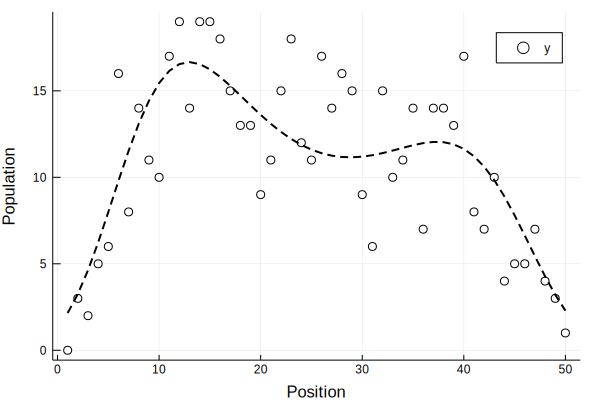

In [4]:
scatter(1:50, df.y, xlabel = "Position", ylabel = "Population", markercolor = :white, label = "y")
plot!(1:50, df.m, linewidth = 2, linecolor = :black, linestyle = :dash, label = "")

## 11.2 階層ベイズモデルに空間構造を組み込む
まず, 個体数$y_i$は, すべでの区画で共通する平均$\lambda$のポアソン分布に従うとしてみる.
\begin{align}
y_i & \sim \text{Poisson}(\lambda),\\
p(y_j \mid \lambda) & = \frac{\lambda^{y_i}\exp(-\lambda)}{y_j!}
\end{align}

このように仮定してすると, 平均$\lambda$と標本平均と等しいとしてみる.
### 標本平均

In [5]:
mean(df.y)

10.88

### 標本分散
ところが標本分散を求めてみると,

In [6]:
var(df.y)

27.373061224489796

となり, 標本平均の3倍近くなっている. そのため個体数が全ての区画で共通する平均$\lambda$のPoisson分布に従うと言う仮定は成立していなさそう.


そのため, 区間$j$ごとに平均$\lambda_i$が異なっているとし, 平均個体数を切片$\beta$と場所差$r_j$を用いて
\begin{align}
\log \lambda_i = \beta + r_j
\end{align}
と表す.
### 11.2.1. 空間構造のない階層事前分布
場所差$r_j$の事前分布を第10章で使ったような階層事前分布
\begin{align}
r_j & \sim \text{Normal}(0, s^2),\\
p(r_j \mid s) & = \frac{1}{\sqrt{2\pi s^2}}\exp \left( -\frac{r_j^2}{2s^2} \right)
\end{align}
であるとしてモデリングしてみる.

In [7]:
model1 = Model(

    y = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[
            (Poisson(lambda[i])) for i in 1:N
        ],
        false
    ),
    
    lambda = Logical(1,
        (beta, r) -> exp.(beta .+ r)),
    
    beta = Stochastic(() -> Normal(0, 100)),
    
    r = Stochastic(1, s -> Normal(0, s), false),
    
    s = Stochastic(() -> Uniform(0, 10000))
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [8]:
data1 = Dict{Symbol, Any}(
    :y => df.y,
    :N => length(df.y),
)

Dict{Symbol,Any} with 2 entries:
  :N => 50
  :y => [0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1]

In [9]:
inits1 = [
    Dict{Symbol, Any}(
        :y => df.y,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[-0.0441422, 0.0981172, 0.291955, 0.108858, 0.188558, -0.0569995, 0.0733, 0.132373, 0.0529651, -0.0722141  …  -0.0674658, 0.105108, 0.0843834, -0.0961611, -0.0949957, 0.0234522, -0.0549651, -0.00579583, -0.0950219, -0.181266])        
 Dict(:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[0.00515683, 0.113405, 0.029479, -0.0964015, -0.0189397, -0.00871576, 0.00392422, 0.140545, -0.05881, -0.014656  …  -0.118118, -0.0361166, 0.00221506, 0.0361541, -0.127298, -0.0715708, -0.0167004, -0.0689592, -0.0357097, 0.00816971]) 
 Dict(:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[-0.00121514, -0.0350449, 0.178549, 0.0725012, -0.0788715, -0.0374632, -0.0679703, 0.000585406, 0.013752, 0.079842  …  -0.0863474, 0.0362508, -0.0107608, 0.0398184, -0.0438461, 0.236133, 

In [10]:
scheme1 = [
    AMWG(:r, 1),
    Slice(:s, 1.0),
    Slice(:beta, 1.0),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:r]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
Symbol[:s]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                    

In [11]:
setsamplers!(model1, scheme1)
sim1 = mcmc(model1, data1, inits1, 60000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 60000 Iterations x 3 Chains...

      From worker 4:	Chain 2:   0% [15:08:12 of 15:08:21 remaining]
      From worker 2:	Chain 1:   0% [15:37:24 of 15:37:33 remaining]
      From worker 3:	Chain 3:   0% [15:53:24 of 15:53:34 remaining]
      From worker 2:	Chain 1:  10% [0:04:52 of 0:05:25 remaining]
      From worker 3:	Chain 3:  10% [0:04:55 of 0:05:27 remaining]
      From worker 4:	Chain 2:  10% [0:04:59 of 0:05:32 remaining]
      From worker 2:	Chain 1:  20% [0:03:47 of 0:04:43 remaining]
      From worker 3:	Chain 3:  20% [0:03:48 of 0:04:45 remaining]
      From worker 4:	Chain 2:  20% [0:03:53 of 0:04:52 remaining]
      From worker 2:	Chain 1:  30% [0:03:09 of 0:04:30 remaining]
      From worker 3:	Chain 3:  30% [0:03:10 of 0:04:32 remaining]
      From worker 4:	Chain 2:  30% [0:03:18 of 0:04:43 remaining]
      From worker 2:	Chain 1:  40% [0:02:43 of 0:04:32 remaining]
      From worker 3:	Chain 3:  40% [0:02:44 of 0:04:33 remaining]
      From worker 4

Object of type "ModelChains"

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

[0.238188 2.3811 … 6.23568 9.45133; 0.34716 2.4358 … 7.9202 5.58499; … ; 0.348919 2.30817 … 6.6893 12.175; 0.586171 2.29918 … 6.70738 3.7195]

[0.5254 2.30391 … 3.78873 2.42258; 0.552967 2.18612 … 5.2244 4.93677; … ; 0.440671 2.36602 … 6.45428 4.90336; 0.297116 2.40776 … 8.71894 6.04451]

[0.379733 2.26192 … 6.24749 4.39306; 0.313801 2.34441 … 8.67647 6.89; … ; 0.497106 2.34148 … 7.39868 2.81663; 0.46077 2.41683 … 4.03718 8.17762]

In [12]:
describe(sim1)

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

Empirical Posterior Estimates:
              Mean        SD       Naive SE        MCSE      ESS
         s  0.4537456 0.08203543 0.0006698165 0.00086594484 5000
      beta  2.2975059 0.08245732 0.0006732612 0.00101041340 5000
 lambda[1]  4.4237718 1.62956259 0.0133053228 0.01447763538 5000
 lambda[2]  5.8677307 1.88110119 0.0153591269 0.01626856412 5000
 lambda[3]  5.3889521 1.79472070 0.0146538331 0.01627404411 5000
 lambda[4]  7.0184112 2.08368767 0.0170132386 0.01704076523 5000
 lambda[5]  7.6057509 2.18772325 0.0178626856 0.01817034116 5000
 lambda[6] 14.2916335 3.28641033 0.0268334280 0.02221648775 5000
 lambda[7]  8.8051683 2.37918567 0.0194259696 0.01975874086 5000
 lambda[8] 12.8792689 3.04305499 0.0248464399 0.02313084474 5000
 lambda[9] 10.7761489 2.68741179 0.0219426253 0.02057431659 5000
lambda[10] 10.1095543 2.60894178 0.0213019204 0.02246680416 5000
lambda[11] 15.0120798 3.37524974 0.

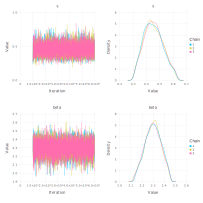

In [13]:
p1 = Mamba.plot(sim1, legend = true)
Mamba.draw(p1[:, 1:2], nrow = 2, ncol = 2)

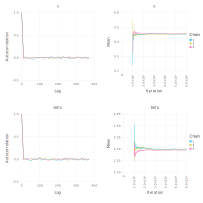

In [14]:
p2 = Mamba.plot(sim1, [:autocor, :mean], legend=true)
Mamba.draw(p2[:, 1:2], nrow = 2, ncol = 2)

$\lambda$の中央値、95%信頼区間をプロットしてみる

In [15]:
mre = quantile(sim1).value[3:end, :]

50×5 Array{Float64,2}:
  1.76625   3.22748   4.26322   5.41116   8.02881
  2.81617   4.51055   5.67641   6.9764   10.0781 
  2.43703   4.09365   5.21241   6.46897   9.33949
  3.57513   5.52202   6.80685   8.26638  11.6379 
  4.01859   6.04775   7.38924   8.91182  12.5316 
  8.74395  11.9413   13.9829   16.3186   21.6177 
  4.80697   7.14286   8.5528   10.2717   14.2137 
  7.71053  10.7173   12.6099   14.7658   19.5996 
  6.2777    8.83972  10.5425   12.4288   16.6956 
  5.74254   8.25845   9.83977  11.6792   15.857  
  9.27597  12.6029   14.7279   17.0713   22.3445 
 10.3598   13.9433   16.2098   18.745    24.3125 
  7.72129  10.6677   12.5847   14.7435   19.5902 
  ⋮                                              
  7.19304  10.0045   11.8482   13.912    18.4066 
  9.19422  12.6165   14.6899   17.1312   22.5439 
  4.81647   7.14037   8.58887  10.2633   14.2432 
  4.4249    6.58939   7.98992   9.59181  13.372  
  5.73954   8.25333   9.87882  11.6741   15.8839 
  3.16878   5.01805   6.233

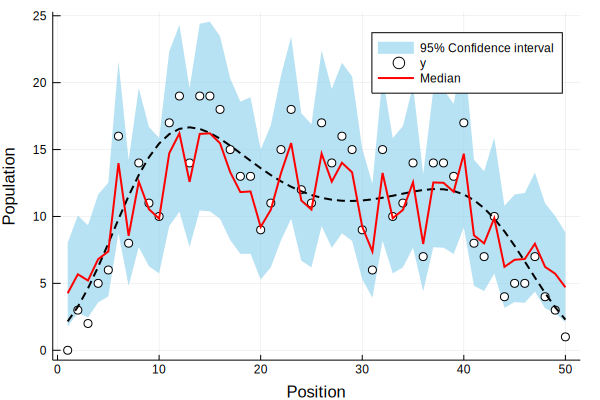

In [16]:
Plots.plot(1:50, mre[:, 1], lw = 0, 
    fillrange = mre[:, 5],
    fillcolor = :skyblue,
    fillalpha = 0.6, 
    label = "95% Confidence interval")
scatter!(1:50, df.y, xlabel = "Position", ylabel = "Population", markercolor = :white, label = "y")
plot!(1:50, df.m, linewidth = 2, linecolor = :black, linestyle = :dash, label = "")
plot!(1:50, mre[:, 3], linewidth = 2, linecolor = :red, label = "Median")

### 11.2.2 空間構造のある階層事前分布
ある区間はそれと隣接する区間とだけ相互作用すると仮定する. 
近傍数は$n_j = 2 \ (j \neq 1, 50), 1 \ (j = 1, 50)$となる.

\begin{align}
\mu_j & = \frac{r_{j-1} + r_{j+1}}{2}\ (j \neq 1, 50), \mu_1 = r_2, \mu_{50} = r_{49},\\
r_j \mid \mu_j, s & \sim \text{Normal}\left(\mu_j, \frac{s}{\sqrt{n_j}}\right)
\end{align}
と言うモデルを考える.
## 11.3 空間統計モデルをデータに当てはめる
CARモデルを実装する。
参考 : https://github.com/matsueushi/lip_stick_mamba

In [17]:
model2 = Model(

    y = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[
            (Poisson(lambda[i])) for i in 1:N
        ],
        false
    ),
    
    lambda = Logical(1,
        (beta, r) -> exp.(beta .+ r)),
    
    beta = Stochastic(() -> Normal(0, 100)),
    
    r = Stochastic(1,
        (s, alpha, N, D, adj) ->
            MvNormalCanon(zeros(N), 1 / (s * s) * (D - alpha * adj)),
        false
    ),
    
    alpha = Stochastic(() -> Uniform()),
    
    s = Stochastic(() -> Uniform(0, 10000))
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
alpha:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [59]:
adj = zeros(50, 50)
for i in 1:50-1
    adj[i, i+1] = 1
    adj[i+1, i] = 1
end
adj

50×50 Array{Float64,2}:
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [60]:
D = Diagonal(vec(sum(adj, dims=2)))

50×50 Diagonal{Float64,Array{Float64,1}}:
 1.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅   2.0   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅   2.0   ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅   2.0   ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅   2.0   ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅   2.0   ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   2.0   ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   2.0      ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅   …   ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅       ⋅    ⋅    ⋅    ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    ⋅    

In [61]:
data2 = Dict{Symbol, Any}(
    :y => df.y,
    :N => length(df.y),
    :adj => adj,
    :D => D,
)

Dict{Symbol,Any} with 4 entries:
  :N   => 50
  :adj => [0.0 1.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 1.0; 0.0 0.0…
  :y   => [0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1]
  :D   => [1.0 0.0 … 0.0 0.0; 0.0 2.0 … 0.0 0.0; … ; 0.0 0.0 … 2.0 0.0; 0.0 0.0…

In [62]:
inits2 = [
    Dict{Symbol, Any}(
        :y => df.y,
        :alpha => 0.9,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:alpha=>0.9,:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[0.148002, 0.0674853, -0.0043824, 0.10461, 0.00278104, -0.0471642, 0.0461415, -0.0333372, 0.139021, 0.105315  …  -0.0797039, -0.0865383, -0.14976, 0.0763664, 0.0291711, -0.0245362, -0.0377342, 0.192356, 0.172444, -0.0564005])      
 Dict(:alpha=>0.9,:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[0.0179771, -0.181622, 0.0893147, 0.0153282, 0.0410324, -0.0644059, -0.0215666, -0.243373, -0.1286, 0.00870049  …  0.108848, -0.024759, 0.151148, 0.140419, 0.125666, -0.0141734, -0.272591, 0.143723, 0.167712, 0.184099])            
 Dict(:alpha=>0.9,:beta=>0.0,:y=>[0, 3, 2, 5, 6, 16, 8, 14, 11, 10  …  8, 7, 10, 4, 5, 5, 7, 4, 3, 1],:s=>1.0,:r=>[-0.0790937, 0.0921514, -0.0269835, -0.0772981, 0.111728, -0.0603492, -0.0988978, 0.0254935, 0.067043, -0.0261745  …  0.183373, -0.0420707, 0.0929655, 0.0449

In [63]:
scheme2 = [
    AMWG(:r, 1),
    Slice(:s, 1.0),
    Slice([:alpha, :beta], 1.0),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:r]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Distributions.Multivariate}}"
Sampling Block Nodes:
Symbol[:s]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                                    

In [64]:
setsamplers!(model2, scheme2)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
alpha:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
r:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [65]:
sim2 = mcmc(model2, data2, inits2, 60000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 60000 Iterations x 3 Chains...

      From worker 3:	Chain 2:   0% [0:21:57 of 0:21:57 remaining]
      From worker 4:	Chain 3:   0% [0:30:02 of 0:30:02 remaining]
      From worker 2:	Chain 1:   0% [0:30:07 of 0:30:07 remaining]
      From worker 4:	Chain 3:  10% [0:03:22 of 0:03:44 remaining]
      From worker 2:	Chain 1:  10% [0:03:24 of 0:03:47 remaining]
      From worker 3:	Chain 2:  10% [0:03:27 of 0:03:50 remaining]
      From worker 2:	Chain 1:  20% [0:02:55 of 0:03:39 remaining]
      From worker 3:	Chain 2:  20% [0:02:57 of 0:03:42 remaining]
      From worker 4:	Chain 3:  20% [0:02:58 of 0:03:42 remaining]
      From worker 2:	Chain 1:  30% [0:02:37 of 0:03:44 remaining]
      From worker 3:	Chain 2:  30% [0:02:39 of 0:03:47 remaining]
      From worker 4:	Chain 3:  30% [0:02:40 of 0:03:49 remaining]
      From worker 2:	Chain 1:  40% [0:02:17 of 0:03:48 remaining]
      From worker 3:	Chain 2:  40% [0:02:18 of 0:03:50 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

[0.263396 0.993482 … 4.25138 3.87156; 0.304108 0.991512 … 3.21633 2.51005; … ; 0.478383 0.914817 … 2.58072 1.42952; 0.368271 0.938262 … 2.10213 2.16242]

[0.316929 0.946992 … 3.02442 2.9427; 0.254499 0.983459 … 4.14902 3.84926; … ; 0.29461 0.975422 … 3.09454 2.12943; 0.271609 0.982278 … 4.14583 2.90855]

[0.268919 0.992521 … 3.1161 2.98899; 0.312498 0.984094 … 3.11401 2.65792; … ; 0.23708 0.920962 … 4.99666 3.17472; 0.421913 0.988001 … 3.93511 2.48131]

In [66]:
describe(sim2)

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

Empirical Posterior Estimates:
               Mean         SD        Naive SE       MCSE         ESS   
         s  0.28701037 0.069616596 0.00056841713 0.0010988047 4014.06669
     alpha  0.97704577 0.026470455 0.00021613036 0.0006229174 1805.76799
      beta  2.26358167 0.345609323 0.00282188831 0.0237995621  210.87882
 lambda[1]  2.80829344 1.066778457 0.00871020963 0.0165310518 4164.35268
 lambda[2]  3.37595950 1.062730816 0.00867716078 0.0174625767 3703.64965
 lambda[3]  4.00549800 1.117701652 0.00912599577 0.0172110643 4217.31783
 lambda[4]  5.35357702 1.307126798 0.01067264561 0.0168874896 5000.00000
 lambda[5]  7.22148152 1.620991086 0.01323533680 0.0186840900 5000.00000
 lambda[6] 10.69804470 2.283013230 0.01864072497 0.0250878459 5000.00000
 lambda[7] 10.21452139 2.028352567 0.01656142936 0.0186438740 5000.00000
 lambda[8] 11.87962548 2.341279979 0.01911647098 0.0233262257 5000.00000
 lam

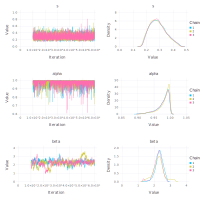

In [67]:
p3 = Mamba.plot(sim2, legend = true)
Mamba.draw(p3[:, 1:3], nrow = 3, ncol = 2)

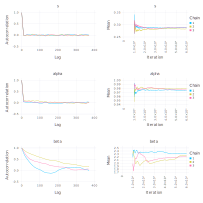

In [68]:
p4 = Mamba.plot(sim2, [:autocor, :mean], legend=true)
Mamba.draw(p4[:, 1:3], nrow = 3, ncol = 2)

In [69]:
mre2 = quantile(sim2).value[4:end, :]

50×5 Array{Float64,2}:
  1.11948   2.03442   2.67401   3.44207   5.22179
  1.61619   2.60351   3.27998   4.01894   5.7458 
  2.11133   3.20244   3.92075   4.69676   6.4455 
  3.09261   4.42984   5.24209   6.14271   8.26534
  4.43373   6.09823   7.08769   8.19048  10.7529 
  6.94111   9.08528  10.4616   11.9997   15.8922 
  6.71485   8.78501  10.0511   11.4578   14.6444 
  7.85907  10.2323   11.6817   13.3126   17.0301 
  7.7545   10.0625   11.5059   13.0176   16.4295 
  8.07359  10.5398   11.9984   13.6081   17.1032 
 10.4455   13.2893   14.9981   16.8663   21.3474 
 11.6626   14.7095   16.5213   18.6083   23.2349 
 10.8381   13.8951   15.5988   17.4837   21.5411 
  ⋮                                              
  8.75921  11.2464   12.7604   14.4725   18.2267 
  8.84487  11.3051   12.889    14.7013   18.7728 
  6.3208    8.35729   9.60429  10.9288   13.9909 
  5.25519   7.09557   8.2014    9.4008   12.1788 
  4.99605   6.67676   7.73877   8.93924  11.843  
  3.71191   5.18415   6.081

### Plotting

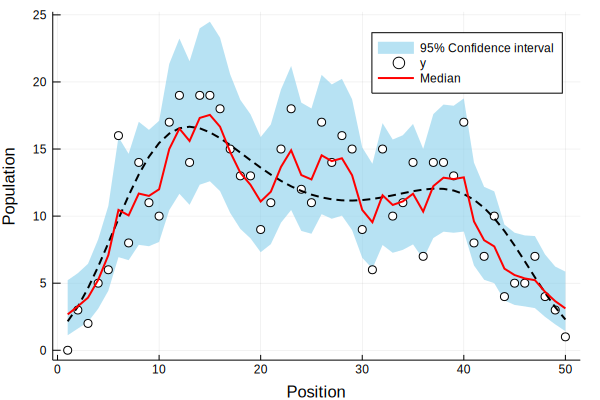

In [70]:
Plots.plot(1:50, mre2[:, 1], lw = 0, 
    fillrange = mre2[:, 5],
    fillcolor = :skyblue,
    fillalpha = 0.6, 
    label = "95% Confidence interval")
scatter!(1:50, df.y, xlabel = "Position", ylabel = "Population", markercolor = :white, label = "y")
plot!(1:50, df.m, linewidth = 2, linecolor = :black, linestyle = :dash, label = "")
plot!(1:50, mre2[:, 3], linewidth = 2, linecolor = :red, label = "Median")

## 11.5 空間相関モデルと欠測のある観測データ
Missing Values Sampler  
https://mambajl.readthedocs.io/en/latest/samplers/miss.html  
を使って、欠測のある観測データを使った予測を行う。
### まずは、空間相関のないモデル

In [71]:
y_missing = convert(Vector{Union{Missing, Float64}}, df.y)
missing_place = [6, 9, 12, 13, 26, 27, 28, 29, 30]
y_missing[missing_place] .= NaN

9-element view(::Array{Union{Missing, Float64},1}, [6, 9, 12, 13, 26, 27, 28, 29, 30]) with eltype Union{Missing, Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [72]:
y_missing

50-element Array{Union{Missing, Float64},1}:
   0.0
   3.0
   2.0
   5.0
   6.0
 NaN  
   8.0
  14.0
 NaN  
  10.0
  17.0
 NaN  
 NaN  
   ⋮  
  13.0
  17.0
   8.0
   7.0
  10.0
   4.0
   5.0
   5.0
   7.0
   4.0
   3.0
   1.0

In [73]:
data1_missing = Dict{Symbol, Any}(
    :y => y_missing,
    :N => length(df.y),
)

Dict{Symbol,Any} with 2 entries:
  :N => 50
  :y => Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 1…

In [74]:
inits1_missing = [
    Dict{Symbol, Any}(
        :y => y_missing,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>0.0,:y=>Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 10.0  …  8.0, 7.0, 10.0, 4.0, 5.0, 5.0, 7.0, 4.0, 3.0, 1.0],:s=>1.0,:r=>[-0.0323783, -0.23834, 0.162363, -0.233799, -0.124608, 0.0348401, -0.0607949, -0.0726172, 0.0553268, -0.186525  …  0.0250505, -0.0675535, -0.0354059, -0.145638, 0.0651399, 0.00707907, 0.0622233, 0.0934892, 0.151132, -0.111696])  
 Dict(:beta=>0.0,:y=>Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 10.0  …  8.0, 7.0, 10.0, 4.0, 5.0, 5.0, 7.0, 4.0, 3.0, 1.0],:s=>1.0,:r=>[-0.124198, 0.0561938, -0.070338, -0.0918001, 0.0749844, -0.0473038, 0.00227479, -0.140902, -0.0686752, -0.124156  …  -0.023932, -0.0618233, -0.109263, -0.1403, 0.00735265, 0.0196531, -0.0774797, -0.0575632, 0.0295506, 0.036984])
 Dict(:beta=>0.0,:y=>Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 10.0  …  8.0, 7.0, 10.0, 4.0, 5.0, 5.0, 7.0, 4.0, 3.0, 1.0],:s=>1.0,:r=>[0.0849817, 0.

In [75]:
scheme1_missing = [
    MISS(:y),
    AMWG(:r, 1),
    Slice(:s, 1.0),
    Slice(:beta, 1.0),
]

4-element Array{Sampler,1}:
 An object of type "Sampler{Dict{Symbol,Mamba.MISSTune}}"
Sampling Block Nodes:
Symbol[:y]

CodeInfo(
1 ─ %1 = π (##262#263(Box(Symbol[:y])), Const(##262#263(Box(Symbol[:y])), false))
│   %2 = (%1)(model, block)::Const(nothing, false)
└──      return %2
) => Nothing
                                                                                                                                                                                                                                     
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:r]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), false))
│   %2 = (%1)(model, block)::Any
└──    

In [76]:
setsamplers!(model1, scheme1_missing)
sim1_missing = mcmc(model1, data1_missing, inits1_missing, 60000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 60000 Iterations x 3 Chains...

      From worker 3:	Chain 2:   0% [0:03:51 of 0:03:51 remaining]
      From worker 4:	Chain 3:   0% [0:04:10 of 0:04:10 remaining]
      From worker 2:	Chain 1:   0% [0:04:00 of 0:04:00 remaining]
      From worker 3:	Chain 2:  10% [0:01:34 of 0:01:44 remaining]
      From worker 2:	Chain 1:  10% [0:01:36 of 0:01:46 remaining]
      From worker 4:	Chain 3:  10% [0:01:42 of 0:01:53 remaining]
      From worker 3:	Chain 2:  20% [0:01:31 of 0:01:54 remaining]
      From worker 2:	Chain 1:  20% [0:01:32 of 0:01:54 remaining]
      From worker 4:	Chain 3:  20% [0:01:36 of 0:01:59 remaining]
      From worker 3:	Chain 2:  30% [0:01:18 of 0:01:51 remaining]
      From worker 2:	Chain 1:  30% [0:01:19 of 0:01:53 remaining]
      From worker 4:	Chain 3:  30% [0:01:22 of 0:01:57 remaining]
      From worker 3:	Chain 2:  40% [0:01:05 of 0:01:49 remaining]
      From worker 2:	Chain 1:  40% [0:01:06 of 0:01:50 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

[0.521439 2.20948 … 4.47957 3.84419; 0.631282 2.16953 … 9.51485 3.1894; … ; 0.518758 2.1899 … 4.61829 4.96633; 0.622778 2.10851 … 5.59226 3.21316]

[0.542375 2.21232 … 4.15066 5.72092; 0.562876 2.01322 … 5.87457 2.53618; … ; 0.366973 2.34958 … 8.19165 7.64962; 0.470608 2.36951 … 6.4258 3.58016]

[0.562277 2.16553 … 2.83394 3.47516; 0.412145 2.16797 … 5.20564 4.79444; … ; 0.423286 2.32788 … 8.38129 6.91415; 0.300323 2.24257 … 5.80743 6.5516]

In [77]:
describe(sim1_missing)

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

Empirical Posterior Estimates:
              Mean         SD       Naive SE       MCSE        ESS   
         s  0.5110166 0.098540743 0.0008045818 0.0014490485 4624.5111
      beta  2.1978810 0.099299465 0.0008107767 0.0012334045 5000.0000
 lambda[1]  3.7835383 1.552161454 0.0126733452 0.0168905492 5000.0000
 lambda[2]  5.3543366 1.840267400 0.0150257204 0.0165284937 5000.0000
 lambda[3]  4.8172772 1.732145442 0.0141429083 0.0164949539 5000.0000
 lambda[4]  6.5106761 2.047679990 0.0167192371 0.0181997544 5000.0000
 lambda[5]  7.1438736 2.161493070 0.0176485170 0.0197294151 5000.0000
 lambda[6] 10.3064819 5.871986381 0.0479445680 0.0790711381 5000.0000
 lambda[7]  8.4347951 2.402653158 0.0196175809 0.0212085564 5000.0000
 lambda[8] 12.7099721 3.149311239 0.0257140186 0.0250435671 5000.0000
 lambda[9] 10.5746572 6.227984355 0.0508512793 0.1003854361 3849.0505
lambda[10]  9.8531959 2.679612534 0.0218

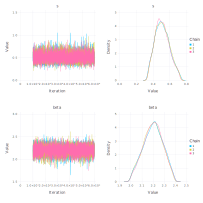

In [78]:
p5 = Mamba.plot(sim1_missing, legend = true)
Mamba.draw(p5[:, 1:2], nrow = 2, ncol = 2)

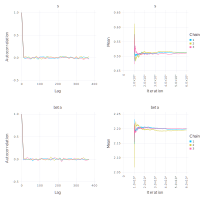

In [79]:
p6 = Mamba.plot(sim1_missing, [:autocor, :mean], legend=true)
Mamba.draw(p6[:, 1:2], nrow = 2, ncol = 2)

### 次に、空間相関のあるモデル

In [80]:
data2_missing = Dict{Symbol, Any}(
    :y => y_missing,
    :N => length(df.y),
    :adj => adj,
    :D => D,
)

Dict{Symbol,Any} with 4 entries:
  :N   => 50
  :adj => [0.0 1.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 1.0; 0.0 0.0…
  :y   => Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN,…
  :D   => [1.0 0.0 … 0.0 0.0; 0.0 2.0 … 0.0 0.0; … ; 0.0 0.0 … 2.0 0.0; 0.0 0.0…

In [81]:
inits2_missing = [
    Dict{Symbol, Any}(
        :y => y_missing,
        :alpha => 0.9,
        :beta => 0.0,
        :r => rand(Normal(0, 0.1), length(df.y)),
        :s => 1.0,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:alpha=>0.9,:beta=>0.0,:y=>Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 10.0  …  8.0, 7.0, 10.0, 4.0, 5.0, 5.0, 7.0, 4.0, 3.0, 1.0],:s=>1.0,:r=>[-0.0380224, -0.092749, 0.171598, 0.156222, -0.0124823, 0.00491581, 0.0845822, -0.137384, 0.116896, -0.104154  …  -0.00600385, -0.0191498, 0.0423706, -0.012424, 0.072972, 0.0416177, 0.00190674, -0.022877, -0.00283335, 0.126916])
 Dict(:alpha=>0.9,:beta=>0.0,:y=>Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 10.0  …  8.0, 7.0, 10.0, 4.0, 5.0, 5.0, 7.0, 4.0, 3.0, 1.0],:s=>1.0,:r=>[-0.0286558, -0.071507, -0.0597947, 0.0321579, 0.0374065, -0.0580291, 0.135077, 0.135072, 0.172162, -0.120898  …  -0.0164184, -0.103509, 0.00906488, -0.124088, 0.0992958, 0.086191, 0.0757271, -0.130866, 0.0242461, 0.118418])    
 Dict(:alpha=>0.9,:beta=>0.0,:y=>Union{Missing, Float64}[0.0, 3.0, 2.0, 5.0, 6.0, NaN, 8.0, 14.0, NaN, 10.0  …  8.0, 7.0, 10.0, 4.0, 5.0, 5.0, 7.0, 4.0, 3.

In [82]:
scheme2_missing = [
    MISS(:y),
    AMWG(:r, 1),
    Slice(:s, 1.0),
    Slice([:alpha, :beta], 1.0),
]

4-element Array{Sampler,1}:
 An object of type "Sampler{Dict{Symbol,Mamba.MISSTune}}"
Sampling Block Nodes:
Symbol[:y]

CodeInfo(
1 ─ %1 = π (##262#263(Box(Symbol[:y])), Const(##262#263(Box(Symbol[:y])), false))
│   %2 = (%1)(model, block)::Const(nothing, false)
└──      return %2
) => Nothing
                                                                                                                                                                                                                                     
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:r]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1), false))
│   %2 = (%1)(model, block)::Any
└──    

In [83]:
setsamplers!(model2, scheme2_missing)
sim2_missing = mcmc(model2, data2_missing, inits2_missing, 60000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 60000 Iterations x 3 Chains...

      From worker 3:	Chain 1:   0% [0:04:22 of 0:04:22 remaining]
      From worker 2:	Chain 2:   0% [0:04:36 of 0:04:36 remaining]
      From worker 4:	Chain 3:   0% [0:05:13 of 0:05:13 remaining]
      From worker 2:	Chain 2:  10% [0:03:03 of 0:03:23 remaining]
      From worker 3:	Chain 1:  10% [0:03:07 of 0:03:27 remaining]
      From worker 4:	Chain 3:  10% [0:03:13 of 0:03:35 remaining]
      From worker 2:	Chain 2:  20% [0:02:53 of 0:03:36 remaining]
      From worker 3:	Chain 1:  20% [0:02:54 of 0:03:37 remaining]
      From worker 4:	Chain 3:  20% [0:02:58 of 0:03:42 remaining]
      From worker 2:	Chain 2:  30% [0:02:27 of 0:03:30 remaining]
      From worker 3:	Chain 1:  30% [0:02:28 of 0:03:31 remaining]
      From worker 4:	Chain 3:  30% [0:02:31 of 0:03:36 remaining]
      From worker 2:	Chain 2:  40% [0:02:04 of 0:03:27 remaining]
      From worker 3:	Chain 1:  40% [0:02:05 of 0:03:28 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

[0.346178 0.976911 … 5.7965 5.69543; 0.40005 0.849989 … 1.82726 2.5951; … ; 0.374561 0.969537 … 2.92188 1.99829; 0.218912 0.991874 … 2.77672 2.35294]

[0.408778 0.959058 … 2.98681 1.49787; 0.330626 0.9951 … 2.69983 1.47606; … ; 0.347708 0.968041 … 2.29862 2.00418; 0.263128 0.991058 … 2.13644 1.90513]

[0.374885 0.938602 … 2.99254 3.45298; 0.27501 0.989892 … 4.05716 2.6636; … ; 0.326795 0.975152 … 3.69407 2.08569; 0.244364 0.963899 … 4.34176 5.42978]

In [84]:
describe(sim2_missing)

Iterations = 10010:60000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 5000

Empirical Posterior Estimates:
               Mean         SD        Naive SE       MCSE        ESS   
         s  0.30993901 0.082784466 0.00067593233 0.0014204568 3396.5782
     alpha  0.97185343 0.034474643 0.00028148428 0.0005964506 3340.8009
      beta  2.22929913 0.285172388 0.00232842280 0.0164894275  299.0913
 lambda[1]  2.62315735 1.035582849 0.00845549855 0.0145019562 5000.0000
 lambda[2]  3.18265912 1.031389536 0.00842126030 0.0153222298 4531.0776
 lambda[3]  3.69971913 1.084835344 0.00885764349 0.0153611670 4987.4578
 lambda[4]  4.85787786 1.293866532 0.01056437600 0.0168555451 5000.0000
 lambda[5]  6.03381753 1.549538369 0.01265192780 0.0194784613 5000.0000
 lambda[6]  7.43034233 2.259339887 0.01844743293 0.0277445886 5000.0000
 lambda[7]  8.78133479 2.006015215 0.01637904565 0.0204833664 5000.0000
 lambda[8] 11.38617893 2.481702138 0.02026301311 0.0246152147 5000.0000
 lambda[9] 11.75

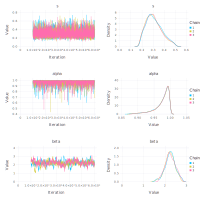

In [85]:
p7 = Mamba.plot(sim2_missing, legend = true)
Mamba.draw(p7[:, 1:3], nrow = 3, ncol = 2)

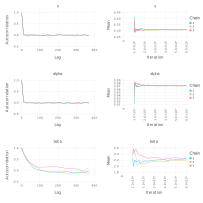

In [86]:
p8 = Mamba.plot(sim2_missing, [:autocor, :mean], legend=true)
Mamba.draw(p8[:, 1:3], nrow = 3, ncol = 2)

### モデルの比較
空間相関のあるモデル・ないモデルを比較する。

In [87]:
scatter_color = fill(:white, 50)
scatter_color[missing_place] .= :black

9-element view(::Array{Symbol,1}, [6, 9, 12, 13, 26, 27, 28, 29, 30]) with eltype Symbol:
 :black
 :black
 :black
 :black
 :black
 :black
 :black
 :black
 :black

In [88]:
vsspan_x = collect(Iterators.flatten(zip(missing_place .- 0.5, missing_place .+ 0.5)))

18-element Array{Float64,1}:
  5.5
  6.5
  8.5
  9.5
 11.5
 12.5
 12.5
 13.5
 25.5
 26.5
 26.5
 27.5
 27.5
 28.5
 28.5
 29.5
 29.5
 30.5

空間相関を考慮していないモデル

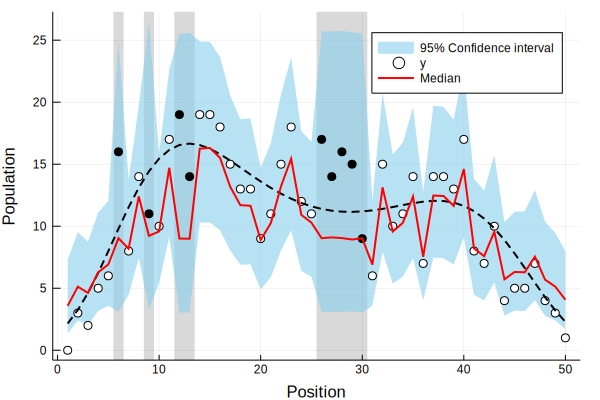

In [89]:
mre3 = quantile(sim1_missing).value[3:end, :]
vspan(vsspan_x, fillcolor = :black, linecolor =:transparent, fillalpha = 0.15, label = "")
plot!(1:50, mre3[:, 1], lw = 0, 
    fillrange = mre3[:, 5],
    fillcolor = :skyblue,
    fillalpha = 0.6, 
    label = "95% Confidence interval")
scatter!(1:50, df.y, xlabel = "Position", ylabel = "Population", markercolor = scatter_color, label = "y")
plot!(1:50, df.m, linewidth = 2, linecolor = :black, linestyle = :dash, label = "")
plot!(1:50, mre3[:, 3], linewidth = 2, linecolor = :red, label = "Median")

空間相関を考慮しているモデル

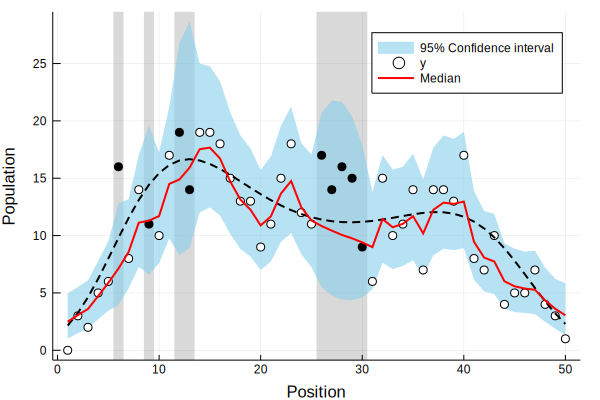

In [90]:
mre4 = quantile(sim2_missing).value[4:end, :]
vspan(vsspan_x, fillcolor = :black, linecolor =:transparent, fillalpha = 0.15, label = "")
plot!(1:50, mre4[:, 1], lw = 0, 
    fillrange = mre4[:, 5],
    fillcolor = :skyblue,
    fillalpha = 0.6, 
    label = "95% Confidence interval")
scatter!(1:50, df.y, xlabel = "Position", ylabel = "Population", markercolor = scatter_color, label = "y")
plot!(1:50, df.m, linewidth = 2, linecolor = :black, linestyle = :dash, label = "")
plot!(1:50, mre4[:, 3], linewidth = 2, linecolor = :red, label = "Median")

空間相関を考慮すると、欠測データに対し隣同士の相互作用を用いた予測ができるため、相関を考慮しないものに比べて予測区間の幅が小さくなる